In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [33]:
base_dir = "/kaggle/input/preprocessed-oasis/keras_png_slices_data"

In the case of our data the test and train data is located in different folders keras_png_slices_data -> keras_png_slices_test and keras_png_slices_train. Each folder contain images with names associated to their labels. For this reason we need to create a custom Dataset for:

* Load images from folders (like MRI scans).
* Convert to grayscale or normalize.Apply on-the-fly transformations (resize, crop, augment).
* Handle labels, paired data, or any custom structure.
  
Dataset(an abstract base class in PyTorch) in a DataLoader to get:
* Batching (get multiple samples at once)
* Shuffling (random order each epoch)
* Parallel loading (multi-threaded loading for speed)


In [34]:
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # helps in finding files
        self.files = [f for f in os.listdir(root_dir) if f.endswith(".png")] # new datase to define all the image names
        self.transform = transform # apply any transformation if needed.

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image

In [35]:
# Transfmrations
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])
#Compose is a wrapper that chains multiple transforms together. Resizes the image to 64×64 pixels.ensures all images are 64×64, so the CNN encoder can process them without shape mismatches. 64x 64 chosen for least memory usage.

In [36]:
#Data Loader
# Make 3 types of data set as an object to the class of pytorch abstract dataset defined earlier each having its own purpose
train_dataset = MRIDataset(os.path.join(base_dir, "keras_png_slices_train"), transform=transform)
val_dataset   = MRIDataset(os.path.join(base_dir, "keras_png_slices_validate"), transform=transform)
test_dataset  = MRIDataset(os.path.join(base_dir, "keras_png_slices_test"), transform=transform)

# Batch size is the number of samples processed together in one forward/backward pass through the neural network.
# 64 MRI images are loaded at a time from train_dataset....
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [37]:
# as the image will have many tensors dataloader helps in parallel loading depending on requirements.

### Variational Auto Encoder

In a Variational Autoencoder (VAE), the encoder compresses your input image into a latent vector z.

In [38]:
# nn.Module is base class for all neural network models in PyTorch. You get features like Parameter tracking, Forward pass definition, Integration with optimizers
class VAE(nn.Module):
    def __init__(self, latent_dim=32):# Rule of thumb: latent dim ≈ 1–10% of input size
        super(VAE, self).__init__() #initializes the base class (nn.Module) so PyTorch can track parameters automatically.
        self.latent_dim = latent_dim # the size of the latent vector z is takenn 32 (64×64 grayscale -> 4096 pixels. 10% = 40–400 )

        # Encoder
        # Convolutional encoder: converts input image to a feature vector.
        # for any Conv2d(input channels, output channels, kernel size/filter, stride(moves 2 pixel at a time), padding)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 64 -> 32 using formula (input is 1 because 1 grayscale image): input image is 64×64, after this convolution with stride 2, the output becomes 32×32.
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16 -> 8
            nn.ReLU(), # activation function, adds non-linearity
            nn.Flatten() # fully connected layer results 128 features each with map size 8 x 8
        )

        ## BOTTLENECK
        
        self.fc_mu = nn.Linear(128*8*8, latent_dim) # stores mean of latent distribution
        self.fc_logvar = nn.Linear(128*8*8, latent_dim) # stores log-variance of latent distribution
# In VAE, we treat latent vector z as a random variable with a Gaussian distribution.
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128*8*8) #nn.Linear(in_features, out_features) is a fully connected (dense) layer in PyTorch. It maps a 1D input vector of size in_features to another 1D output vector of size out_features.

        
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d is like the reverse of Conv2d.
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # 32 -> 64
            nn.Sigmoid() # nn.Sigmoid() ensures output is between 0 and 1 (good for grayscale images).
        )

    def encode(self, x):
        x_enc = self.encoder(x) # encoder function brings out the laten dim distb
        mu = self.fc_mu(x_enc) # finds the mean
        logvar = self.fc_logvar(x_enc) # fins the log var
        return mu, logvar
# Passes input through encoder → flattened features → computes mean and log variance of latent distribution.
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Allows backpropagation through the stochastic sampling.
        return mu + eps * std
# Samples z from the latent distribution using: z=μ+σ⋅ϵ
    def decode(self, z):
        x = self.decoder_input(z) # get tjhe sample 
        x = x.view(-1, 128, 8, 8) # 128*8*8 - > [batch, 128, 8, 8]
        x = self.decoder(x) # expects input: [batch, 128, 8, 8]
        return x
# Maps latent vector z back to a reconstructed image. x.view(-1, 128, 8, 8) reshapes the flat vector to feed into convolutional decoder.
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
#Forward propogation:
# 1. Encode input → mu, logvar
# 2. Sample z using reparameterization
# 3. Decode z → reconstructed image
# 4. Return reconstructed image, mean, and log-variance (needed for loss function)


In [39]:
# Loss Function
# mean squared error:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum') # sums over all pixels (not averaged).
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss
    # Measures how close the reconstructed image is to the original image.:
        # Input image → fed into the encoder
        # Encoder outputs latent distribution parameters
        # Sample z from this distribution
        # Decoder takes z → produces reconstructed image

In [42]:
# Training Loop:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3) # the optimizer updates the model’s weights to minimize the loss function. It decides how to change weights based on the gradients computed during backpropagation. Adam stands for Adaptive Moment Estimation. Adaptive learning rates for each parameter. Converges faster and more reliably than simple stochastic gradient descent (SGD)
# learning rate (lr) optimal - 0.001
epochs = 30
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = model(imgs)
        loss = vae_loss(recon_imgs, imgs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_dataset):.4f}")

Using device: cuda


Epoch 1: 100%|██████████| 151/151 [00:24<00:00,  6.08it/s]


Epoch 1, Loss: 58.4670


Epoch 2: 100%|██████████| 151/151 [00:25<00:00,  5.95it/s]


Epoch 2, Loss: 25.5068


Epoch 3: 100%|██████████| 151/151 [00:24<00:00,  6.09it/s]


Epoch 3, Loss: 22.9670


Epoch 4: 100%|██████████| 151/151 [00:26<00:00,  5.66it/s]


Epoch 4, Loss: 19.7239


Epoch 5: 100%|██████████| 151/151 [00:30<00:00,  4.96it/s]


Epoch 5, Loss: 18.5513


Epoch 6: 100%|██████████| 151/151 [00:30<00:00,  4.91it/s]


Epoch 6, Loss: 18.0342


Epoch 7: 100%|██████████| 151/151 [00:30<00:00,  4.97it/s]


Epoch 7, Loss: 17.7878


Epoch 8: 100%|██████████| 151/151 [00:30<00:00,  4.95it/s]


Epoch 8, Loss: 17.6478


Epoch 9: 100%|██████████| 151/151 [00:29<00:00,  5.05it/s]


Epoch 9, Loss: 17.5889


Epoch 10: 100%|██████████| 151/151 [00:30<00:00,  5.00it/s]


Epoch 10, Loss: 17.5349


Epoch 11: 100%|██████████| 151/151 [00:30<00:00,  4.95it/s]


Epoch 11, Loss: 17.4673


Epoch 12: 100%|██████████| 151/151 [00:30<00:00,  5.00it/s]


Epoch 12, Loss: 17.3998


Epoch 13: 100%|██████████| 151/151 [00:30<00:00,  4.99it/s]


Epoch 13, Loss: 17.3794


Epoch 14: 100%|██████████| 151/151 [00:29<00:00,  5.04it/s]


Epoch 14, Loss: 17.3506


Epoch 15: 100%|██████████| 151/151 [00:29<00:00,  5.04it/s]


Epoch 15, Loss: 17.2711


Epoch 16: 100%|██████████| 151/151 [00:29<00:00,  5.08it/s]


Epoch 16, Loss: 17.2243


Epoch 17: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s]


Epoch 17, Loss: 17.1880


Epoch 18: 100%|██████████| 151/151 [00:27<00:00,  5.53it/s]


Epoch 18, Loss: 17.1788


Epoch 19: 100%|██████████| 151/151 [00:26<00:00,  5.73it/s]


Epoch 19, Loss: 17.1572


Epoch 20: 100%|██████████| 151/151 [00:26<00:00,  5.64it/s]


Epoch 20, Loss: 17.1298


Epoch 21: 100%|██████████| 151/151 [00:27<00:00,  5.57it/s]


Epoch 21, Loss: 17.0863


Epoch 22: 100%|██████████| 151/151 [00:27<00:00,  5.57it/s]


Epoch 22, Loss: 17.0540


Epoch 23: 100%|██████████| 151/151 [00:27<00:00,  5.47it/s]


Epoch 23, Loss: 17.0922


Epoch 24: 100%|██████████| 151/151 [00:28<00:00,  5.34it/s]


Epoch 24, Loss: 17.0371


Epoch 25: 100%|██████████| 151/151 [00:28<00:00,  5.36it/s]


Epoch 25, Loss: 17.0171


Epoch 26: 100%|██████████| 151/151 [00:26<00:00,  5.62it/s]


Epoch 26, Loss: 16.9735


Epoch 27: 100%|██████████| 151/151 [00:27<00:00,  5.41it/s]


Epoch 27, Loss: 16.9274


Epoch 28: 100%|██████████| 151/151 [00:26<00:00,  5.74it/s]


Epoch 28, Loss: 16.9538


Epoch 29: 100%|██████████| 151/151 [00:26<00:00,  5.68it/s]


Epoch 29, Loss: 16.9460


Epoch 30: 100%|██████████| 151/151 [00:26<00:00,  5.73it/s]

Epoch 30, Loss: 16.8952


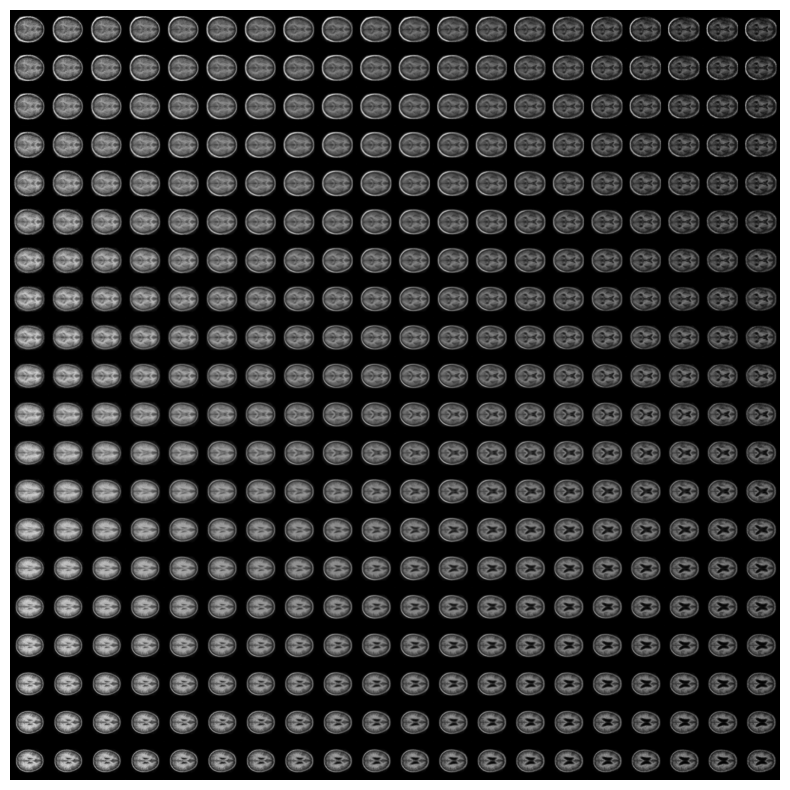

In [45]:
#2D Latent Space Visualization

n = 20
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

model.eval()
figure = np.zeros((64*n, 64*n))  # 64x64 per image
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        recon = model.decode(z).cpu().detach().numpy()
        recon = recon[0,0]
        figure[i*64:(i+1)*64, j*64:(j+1)*64] = recon

plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.savefig("vae_latent.png")
plt.show()